In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import torch
import numpy as np
import cvxpy as cp
from scipy.stats import norm
from osmm import OSMM

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
CPU = torch.device('cpu')
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda')
else:
    torch.set_default_tensor_type(torch.FloatTensor)
    device = CPU
print("device =", device)

device = cuda


## generate data

In [4]:
eta = 0.8
N = 1000000
m = 100
n = m * 3 + 1
n_w = m * 3

In [5]:
np.random.seed(0)
sigma = 1.0 / np.sqrt(2)
NFACT = 5
factors_stock = np.random.randn(m, NFACT)
Sigma = (factors_stock.dot(factors_stock.T) / NFACT + np.eye(m)) * (sigma ** 2)
mu = 0.03 * np.sqrt(np.diag(Sigma)) - np.diag(Sigma) / 2

call_strike_prices = np.exp(norm.ppf(0.8) * np.sqrt(np.diag(Sigma)) + mu)
put_strike_prices = np.exp(norm.ppf(0.2) * np.sqrt(np.diag(Sigma)) + mu)

r = np.zeros(m)
d1_call = np.log(1.0 / call_strike_prices) / np.sqrt(np.diag(Sigma)) + 0.5 * np.sqrt(np.diag(Sigma)) + r / np.sqrt(
    np.diag(Sigma))
d2_call = np.log(1.0 / call_strike_prices) / np.sqrt(np.diag(Sigma)) - 0.5 * np.sqrt(np.diag(Sigma)) + r / np.sqrt(
    np.diag(Sigma))
call_option_prices = norm.cdf(d1_call) - call_strike_prices * norm.cdf(d2_call) * np.exp(-r)

d1_put = np.log(1.0 / put_strike_prices) / np.sqrt(np.diag(Sigma)) + 0.5 * np.sqrt(np.diag(Sigma)) + r / np.sqrt(
    np.diag(Sigma))
d2_put = np.log(1.0 / put_strike_prices) / np.sqrt(np.diag(Sigma)) - 0.5 * np.sqrt(np.diag(Sigma)) + r / np.sqrt(
    np.diag(Sigma))
put_option_prices = put_strike_prices * norm.cdf(-d2_put) * np.exp(-r) - norm.cdf(-d1_put)

In [6]:
def generate_random_data():
    total_return = np.zeros((N, n_w))
    stock_price = np.exp(np.random.multivariate_normal(mu, Sigma, size=int(N))) #N by m
    total_return[:, 0:m] = stock_price
    stock_price_minus_call_strike_price = (stock_price.T - call_strike_prices.reshape((m, 1))).T
    total_return[:, m:2 * m] = np.maximum(0, stock_price_minus_call_strike_price) / call_option_prices
    put_strike_price_minus_stock_price = (put_strike_prices.reshape((m, 1)) - stock_price.T).T
    total_return[:, 2 * m:3 * m] = np.maximum(0, put_strike_price_minus_stock_price) / put_option_prices
    return total_return.T

In [7]:
W = generate_random_data()
W_validation = generate_random_data()

## define g and f

In [8]:
def my_g_cvxpy():
    b_var = cp.Variable(n)
    g = 0
    constr = [cp.sum(b_var[1:n]) == 1, b_var[1:n] >= -0.1,
              cp.sum(cp.abs(b_var[1:n])) <= 1.6]
    return b_var, g, constr

In [9]:
def my_f_torch(b_torch, W_torch):
    tmp = torch.matmul(W_torch.T, b_torch[1:n])
    objf = 1.0 / (1.0 - eta) * torch.mean(torch.relu(-tmp + b_torch[0])) - b_torch[0]
    return objf

## consturct osmm object and pass in data

In [10]:
osmm_prob = OSMM(my_f_torch, my_g_cvxpy)
osmm_prob.f_torch.W = W

## solve

In [11]:
init_val = np.ones(n) / (n - 1)
osmm_prob.solve(init_val, verbose=True, 
#                 use_termination_criteria=False
               )

iter = 10, objf = -8.344e-01, lower bound = -1.009e+00, RMS residual = 5.439e-01, ||G||_F = 6.511e+01
iter = 20, objf = -9.218e-01, lower bound = -1.002e+00, RMS residual = 4.544e-01, ||G||_F = 1.472e+02
iter = 30, objf = -9.309e-01, lower bound = -1.002e+00, RMS residual = 1.118e-01, ||G||_F = 1.094e+02
iter = 40, objf = -9.394e-01, lower bound = -1.002e+00, RMS residual = 1.159e-01, ||G||_F = 1.161e+02
iter = 50, objf = -9.425e-01, lower bound = -9.629e-01, RMS residual = 2.689e-02, ||G||_F = 1.152e+02
iter = 60, objf = -9.429e-01, lower bound = -9.545e-01, RMS residual = 1.019e-02, ||G||_F = 1.219e+02
iter = 70, objf = -9.430e-01, lower bound = -9.484e-01, RMS residual = 1.236e-02, ||G||_F = 1.283e+02
iter = 80, objf = -9.430e-01, lower bound = -9.457e-01, RMS residual = 4.045e-03, ||G||_F = 1.368e+02
iter = 90, objf = -9.430e-01, lower bound = -9.445e-01, RMS residual = 2.737e-03, ||G||_F = 1.427e+02
iter = 100, objf = -9.430e-01, lower bound = -9.439e-01, RMS residual = 1.147e-03,

-0.9429908990859985

## plot result

In [12]:
total_iters = osmm_prob.method_results["total_iters"]
iters = np.array([i for i in range(0, total_iters + 1)])

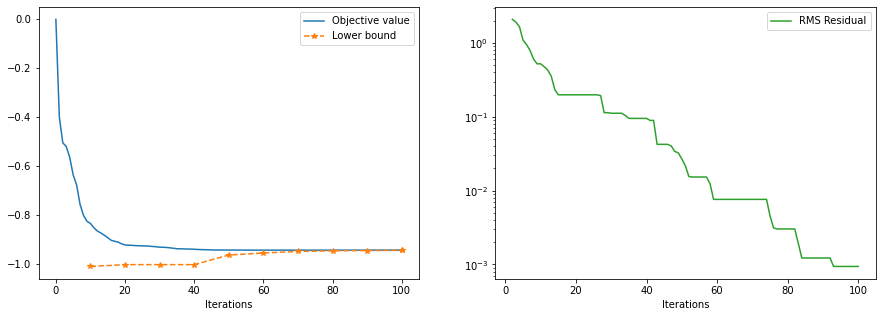

In [13]:
fig = plt.figure(tight_layout=False, figsize=(15, 5))
gs = gridspec.GridSpec(1, 2)

plot1 = fig.add_subplot(gs[0, 0])
plot1.plot(iters, osmm_prob.method_results["objf_iters"][0:total_iters + 1], label="Objective value")
lower_bound_idxs = [i for i in range(0, total_iters + 1, 10)] + [total_iters]
plot1.plot(iters[lower_bound_idxs], osmm_prob.method_results["lower_bound_iters"][lower_bound_idxs], 
           '--*', label="Lower bound")

plot1.set_xlabel("Iterations")
plot1.legend()

#=========================================================================================================
plot2 = fig.add_subplot(gs[0, 1])
start_idx = 2
rms_res_running_min = np.array(osmm_prob.method_results["rms_res_iters"][0:total_iters + 1])
for i in range(start_idx, total_iters + 1):
    rms_res_running_min[i] = np.min(osmm_prob.method_results["rms_res_iters"][start_idx:i + 1])

plot2.plot(iters[start_idx::], rms_res_running_min[start_idx::], label="RMS Residual", color='#2ca02c')

plot2.set_xlabel("Iterations")
plot2.set_yscale("log")
plot2.legend()

<ipython-input-15-80d4d2b9ec01>:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  a.stem([i for i in range(1, n)], osmm_prob.method_results["soln"][1:n], markerfmt=' ', label="Long", linefmt="blue")
<ipython-input-15-80d4d2b9ec01>:9: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  a.stem([i for i in range(1, n)], -osmm_prob.method_results["soln"][1:n], markerfmt=' ', label="Short", linefmt="green")


mean 1.0133014801817346


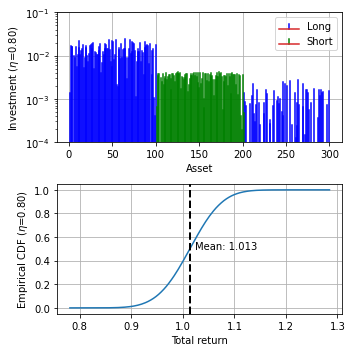

In [15]:
linewidth = 2
fontsize = 10

fig = plt.figure(tight_layout=True, figsize=(5, 5))
gs = gridspec.GridSpec(2, 1)

a = fig.add_subplot(gs[0, 0])
a.stem([i for i in range(1, n)], osmm_prob.method_results["soln"][1:n], markerfmt=' ', label="Long", linefmt="blue")
a.stem([i for i in range(1, n)], -osmm_prob.method_results["soln"][1:n], markerfmt=' ', label="Short", linefmt="green")
a.set_ylabel("Investment ($\eta$={:.2f})".format(eta), fontsize=fontsize)
a.set_xlabel("Asset", fontsize=fontsize)
a.set_yscale("log")
a.set_ylim([1e-4, 1e-1])
a.grid()
plt.legend(fontsize=fontsize)

###################################################################
payoff_outcomes = W.T.dot(osmm_prob.method_results["soln"][1:n])
c = fig.add_subplot(gs[1, 0])
counts, bin_edges = np.histogram(payoff_outcomes, bins=200, density=True)
cdf = np.cumsum(counts)
c.plot(bin_edges[1:], cdf / cdf[-1])
c.set_ylabel(r"Empirical CDF ($\eta$={:.2f})".format(eta), fontsize=fontsize)
c.set_xlabel("Total return", fontsize=fontsize)
c.axvline(payoff_outcomes.mean(), color='k', linestyle='dashed', linewidth=linewidth)
c.text(payoff_outcomes.mean() * 1.01, 0.5, 'Mean: {:.3f}'.format(payoff_outcomes.mean()), fontsize=fontsize)
print("mean", payoff_outcomes.mean())
c.grid()

In [17]:
print("loss probability (per month) =", np.sum(W.T.dot(osmm_prob.method_results["soln"][1::]) < 1) / N)
print("mean (per month) =", np.mean(W.T.dot(osmm_prob.method_results["soln"][1::])))
print("std (per month) =", np.std(W.T.dot(osmm_prob.method_results["soln"][1::])))

loss probability = 0.393304
mean = 1.0133014801817346
std = 0.04995368259515352


In [19]:
year_returns = np.zeros((12, N))
year_returns[0, :] = W.T.dot(osmm_prob.method_results["soln"][1::])
for i in range(1, 12):
    W_new_month = generate_random_data()
    new_returns = W_new_month.T.dot(osmm_prob.method_results["soln"][1::])
    print(i, np.mean(new_returns), np.std(new_returns))
    year_returns[i, :] = new_returns

1 1.0132777641661834 0.04997128253008934
2 1.013347396077748 0.04992464994519233
3 1.0133640837338065 0.04994602838762921
4 1.0132991789611836 0.04995239597485239
5 1.0134433233583442 0.0498741774556682
6 1.013335223206316 0.04989328878154482
7 1.0133591333964342 0.04994957368325398
8 1.013320319127415 0.049870959774091436
9 1.0132721154521578 0.04988471698936681
10 1.013382569382783 0.04987858370210424
11 1.0133460542167436 0.04986901908382489


In [20]:
acc_year_returns = np.exp(np.sum(np.log(year_returns), axis=0))
print("mean (per year) =", np.mean(acc_year_returns))
print("std (per year) =", np.std(acc_year_returns))
print("loss probability (per year) =", np.sum(acc_year_returns <= 1) / N)

mean (per year) = 1.1723135357811665
std (per year) = 0.20132428258452975
loss probability (per year) = 0.198774
